In [43]:
# Import all necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# System utilities
import os
import sys
import time
import pickle

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Advanced models
try:
    import xgboost as xgb
    print("XGBoost available")
except ImportError:
    print("XGBoost not installed")
    xgb = None

try:
    import lightgbm as lgb
    print("LightGBM available")
except ImportError:
    print("LightGBM not installed")
    lgb = None

try:
    import catboost as cb
    print("CatBoost available")
except ImportError:
    print("CatBoost not installed")
    cb = None

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plotting settings
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

print(f"\nPython version: {sys.version}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")

XGBoost available
LightGBM available
CatBoost available

Python version: 3.13.5 (tags/v3.13.5:6cb20a2, Jun 11 2025, 16:15:46) [MSC v.1943 64 bit (AMD64)]
NumPy version: 2.3.5
Pandas version: 2.3.3
Scikit-learn version: 1.7.2


## 1. Exploratory Data Analysis

This section focuses on a comprehensive analysis of the dataset to understand the underlying patterns and anomalies.

In [44]:
# Load data
data_folder = "../data/"
train_data = pd.read_csv(data_folder + "training_data.csv")
test_data = pd.read_csv(data_folder + "test_data.csv")

# Convert timestamps
train_data['timestamp'] = pd.to_datetime(train_data['timestamp'])
test_data['timestamp'] = pd.to_datetime(test_data['timestamp'])

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nTraining date range: {train_data['timestamp'].min()} to {train_data['timestamp'].max()}")
print(f"Test date range: {test_data['timestamp'].min()} to {test_data['timestamp'].max()}")

Training data shape: (208910, 21)
Test data shape: (52228, 20)

Training date range: 2013-01-01 00:00:00 to 2016-12-31 04:10:00
Test date range: 2016-12-31 04:20:00 to 2018-01-13 00:00:00


### 1.1 Analysis of Negative Power Values

Negative power values are investigated as they may indicate specific turbine states such as power consumption during startup, maintenance, or measurement errors.

Power Value Analysis:
Negative power samples: 39,235 (18.78%)
Zero power samples: 4,413 (2.11%)
Low power (<10 kW): 47,056 (22.52%)

Negative power statistics:
count    39235.000000
mean        -1.029251
std          1.686474
min        -18.490000
25%         -1.080000
50%         -0.480000
75%         -0.070000
max         -0.010000
Name: active_power, dtype: float64


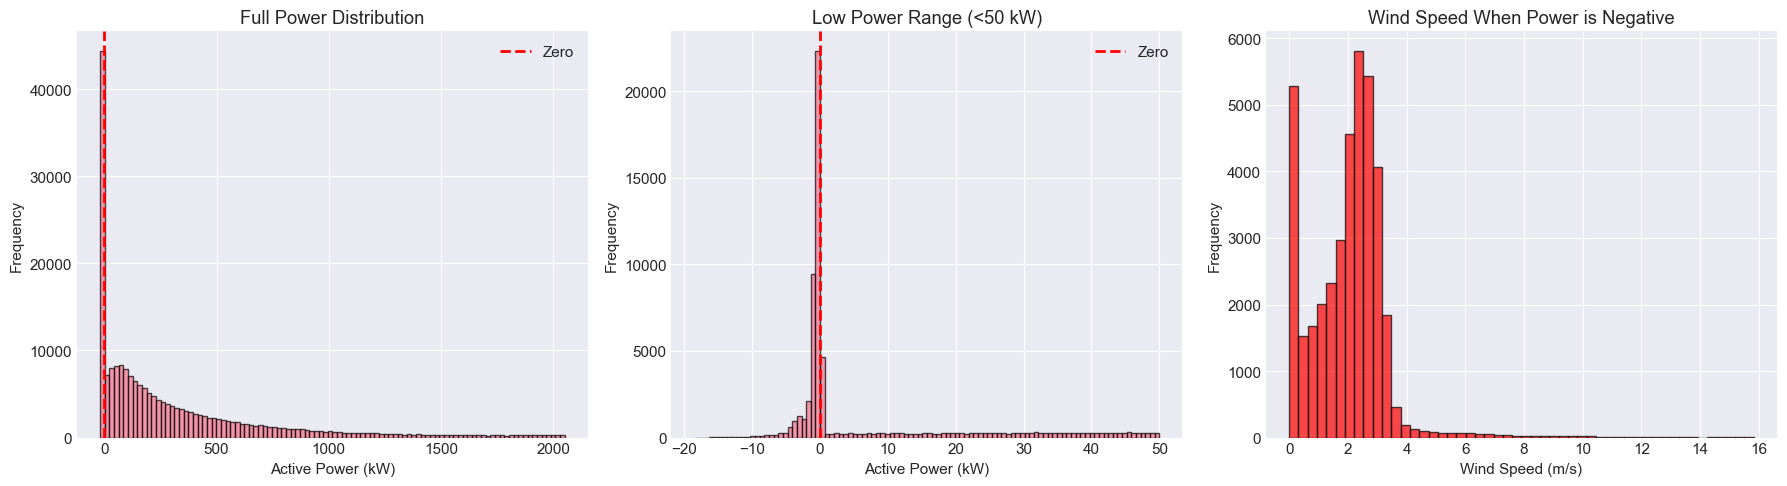

In [45]:
# Analyze negative and zero power values
negative_power = train_data[train_data['active_power'] < 0]
zero_power = train_data[train_data['active_power'] == 0]
low_power = train_data[train_data['active_power'] < 10]

print("Power Value Analysis:")
print("=" * 80)
print(f"Negative power samples: {len(negative_power):,} ({len(negative_power)/len(train_data)*100:.2f}%)")
print(f"Zero power samples: {len(zero_power):,} ({len(zero_power)/len(train_data)*100:.2f}%)")
print(f"Low power (<10 kW): {len(low_power):,} ({len(low_power)/len(train_data)*100:.2f}%)")
print(f"\nNegative power statistics:")
print(negative_power['active_power'].describe())

# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Full distribution
axes[0].hist(train_data['active_power'], bins=100, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[0].set_xlabel('Active Power (kW)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Full Power Distribution')
axes[0].legend()

# Negative and low power zoom
axes[1].hist(train_data[train_data['active_power'] < 50]['active_power'], bins=100, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].set_xlabel('Active Power (kW)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Low Power Range (<50 kW)')
axes[1].legend()

# Wind speed for negative power
if len(negative_power) > 0:
    axes[2].hist(negative_power['wind_speed_avg'], bins=50, edgecolor='black', alpha=0.7, color='red')
    axes[2].set_xlabel('Wind Speed (m/s)')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Wind Speed When Power is Negative')

plt.tight_layout()
plt.show()

### 1.2 Identification of Turbine Operational States

Wind turbines exhibit distinct operational modes based on wind speed and control settings:
- **Shutdown**: Pitch angle > 40° (blades feathered).
- **Startup**: Low wind speed, ramping up.
- **Normal Operation**: Standard power generation.
- **Rated Power**: Operation at maximum capacity (approx. 2050 kW).
- **Cut-out**: Emergency shutdown due to high wind speeds.

Pitch Angle Analysis (key operational indicator):
count    208910.000000
mean         10.598804
std          23.263701
min        -121.260000
25%          -0.990000
50%          -0.990000
75%           0.500000
max         119.070000
Name: pitch_angle, dtype: float64

Operational State Distribution:
--------------------------------------------------------------------------------
normal         :  151,119 samples (72.34%)
shutdown       :   40,801 samples (19.53%)
low_wind       :    9,722 samples ( 4.65%)
idle           :    6,520 samples ( 3.12%)
rated          :      748 samples ( 0.36%)


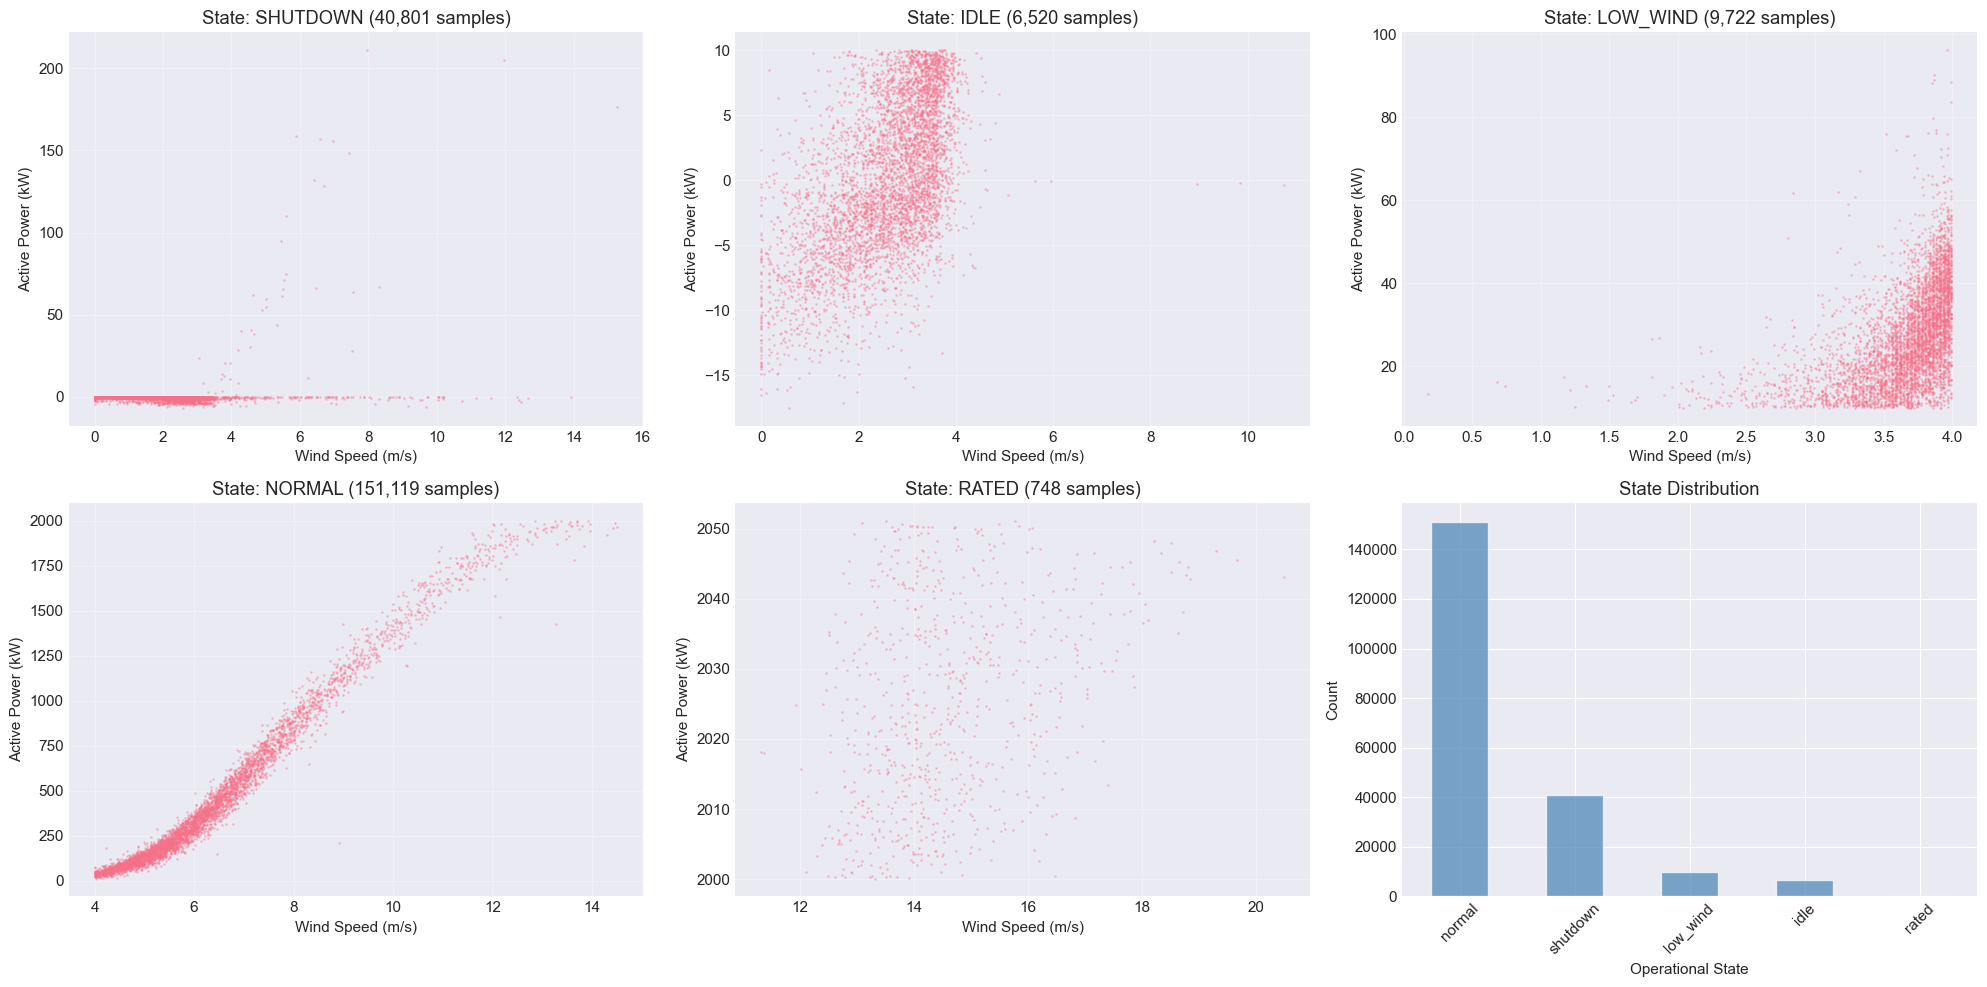

In [46]:
# Analyze pitch angle - key indicator of turbine state
print("Pitch Angle Analysis (key operational indicator):")
print("=" * 80)
print(train_data['pitch_angle'].describe())

# Create operational state categories
def categorize_state(row, has_target=True):
    """Categorize turbine operational state"""
    if row['pitch_angle'] > 40:
        return 'shutdown'
    elif has_target and row['active_power'] < 10:
        return 'idle'
    elif has_target and row['active_power'] >= 2000:
        return 'rated'
    elif row['wind_speed_avg'] < 4:
        return 'low_wind'
    else:
        return 'normal'

# Apply to training data (has active_power)
train_data['operational_state'] = train_data.apply(lambda row: categorize_state(row, has_target=True), axis=1)

# Apply to test data (no active_power - use simplified logic based only on pitch and wind speed)
test_data['operational_state'] = test_data.apply(lambda row: categorize_state(row, has_target=False), axis=1)

# Count states
state_counts = train_data['operational_state'].value_counts()
print("\nOperational State Distribution:")
print("-" * 80)
for state, count in state_counts.items():
    print(f"{state:15s}: {count:8,} samples ({count/len(train_data)*100:5.2f}%)")

# Visualize states
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for idx, state in enumerate(['shutdown', 'idle', 'low_wind', 'normal', 'rated']):
    state_data = train_data[train_data['operational_state'] == state]
    if len(state_data) > 0:
        sample_size = min(5000, len(state_data))
        sample = state_data.sample(sample_size)
        
        axes[idx].scatter(sample['wind_speed_avg'], sample['active_power'], alpha=0.3, s=1)
        axes[idx].set_xlabel('Wind Speed (m/s)')
        axes[idx].set_ylabel('Active Power (kW)')
        axes[idx].set_title(f'State: {state.upper()} ({len(state_data):,} samples)')
        axes[idx].grid(True, alpha=0.3)

# Overall distribution in last subplot
state_counts.plot(kind='bar', ax=axes[5], color='steelblue', alpha=0.7)
axes[5].set_xlabel('Operational State')
axes[5].set_ylabel('Count')
axes[5].set_title('State Distribution')
axes[5].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 1.3 Wind Speed Analysis

Wind speed is the primary predictor of power output. This section analyzes the distribution and characteristics of wind speed measurements.

Wind Speed Statistics:
         wind_speed1    wind_speed2  wind_speed_avg
count  208910.000000  208910.000000   208910.000000
mean        5.245032       5.309963        5.277553
std         2.606739       2.478537        2.535224
min         0.000000       0.000000        0.000000
25%         3.790000       3.930000        3.860000
50%         5.290000       5.350000        5.320000
75%         6.620000       6.640000        6.630000
max        21.280001      19.990000       20.570000

Wind Speed Sensor Difference:
Mean difference: 0.238 m/s
Max difference: 8.980 m/s
Samples with >2 m/s difference: 986

Power Statistics by Wind Speed Range:
--------------------------------------------------------------------------------
                 mean         std        min          max  count
wind_bin                                                        
(0, 3]      -0.502170    2.891410  -18.49000    61.869999  34970
(3, 4]      16.996120   16.227883  -15.96000   118.320000  15726
(4, 5]   

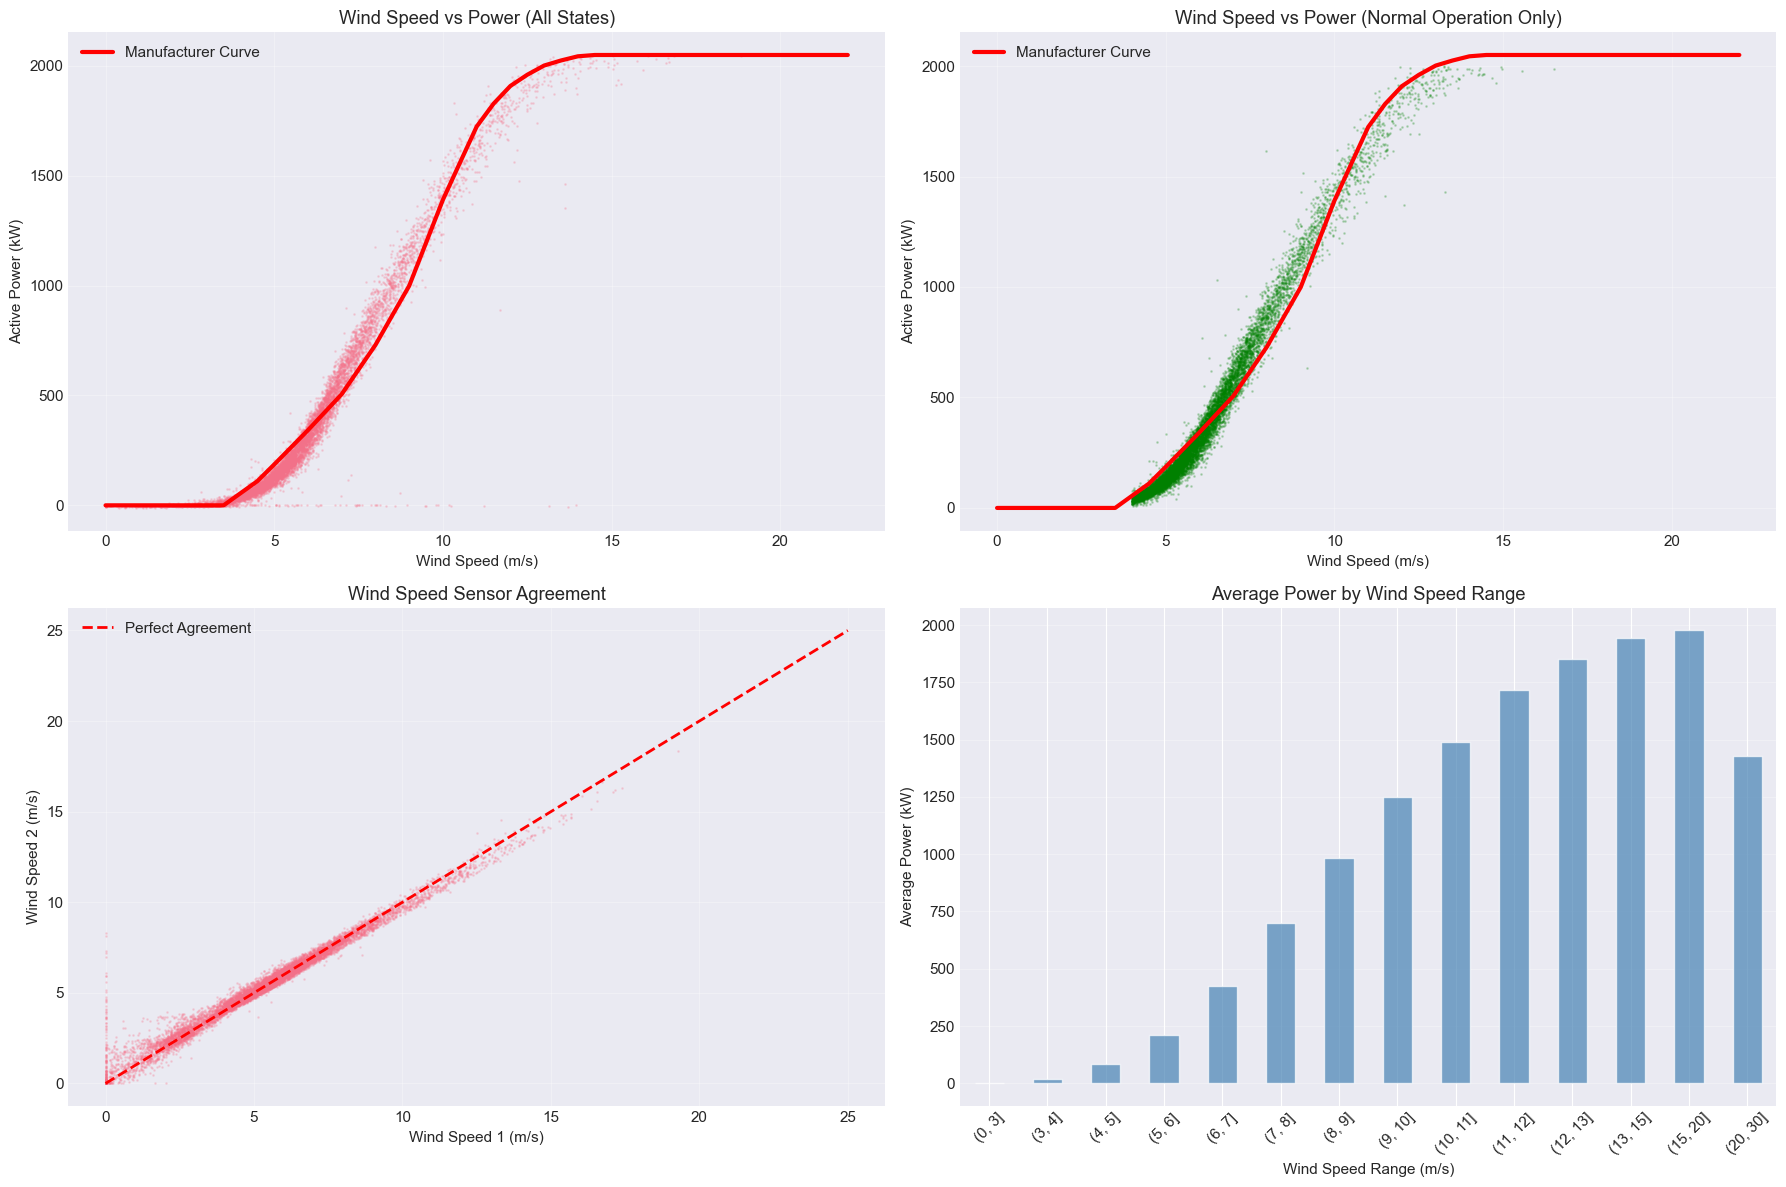

In [47]:
# Detailed wind speed analysis
print("Wind Speed Statistics:")
print("=" * 80)
print(train_data[['wind_speed1', 'wind_speed2', 'wind_speed_avg']].describe())

# Check sensor agreement
train_data['wind_speed_diff'] = np.abs(train_data['wind_speed1'] - train_data['wind_speed2'])
print(f"\nWind Speed Sensor Difference:")
print(f"Mean difference: {train_data['wind_speed_diff'].mean():.3f} m/s")
print(f"Max difference: {train_data['wind_speed_diff'].max():.3f} m/s")
print(f"Samples with >2 m/s difference: {(train_data['wind_speed_diff'] > 2).sum():,}")

# Analyze power by wind speed bins
wind_bins = [0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 20, 30]
train_data['wind_bin'] = pd.cut(train_data['wind_speed_avg'], bins=wind_bins)

wind_power_stats = train_data.groupby('wind_bin')['active_power'].agg(['mean', 'std', 'min', 'max', 'count'])
print("\nPower Statistics by Wind Speed Range:")
print("-" * 80)
print(wind_power_stats)

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Wind speed vs power (with manufacturer curve)
theo_speeds = np.arange(0, 22.5, 0.5)
theo_powers = [0, 0, 0, 0, 0, 0, 0, 0, 55, 110, 186, 264, 342, 424, 506, 618, 730, 865, 999, 1195, 1391, 1558, 1724, 1828, 1909, 1960, 2002, 2025, 2044,
               2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050, 2050]

sample = train_data.sample(min(10000, len(train_data)))
axes[0, 0].scatter(sample['wind_speed_avg'], sample['active_power'], alpha=0.2, s=1)
axes[0, 0].plot(theo_speeds, theo_powers, 'r-', linewidth=3, label='Manufacturer Curve')
axes[0, 0].set_xlabel('Wind Speed (m/s)')
axes[0, 0].set_ylabel('Active Power (kW)')
axes[0, 0].set_title('Wind Speed vs Power (All States)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Normal operation only
normal_data = train_data[train_data['operational_state'] == 'normal']
sample_normal = normal_data.sample(min(10000, len(normal_data)))
axes[0, 1].scatter(sample_normal['wind_speed_avg'], sample_normal['active_power'], alpha=0.2, s=1, color='green')
axes[0, 1].plot(theo_speeds, theo_powers, 'r-', linewidth=3, label='Manufacturer Curve')
axes[0, 1].set_xlabel('Wind Speed (m/s)')
axes[0, 1].set_ylabel('Active Power (kW)')
axes[0, 1].set_title('Wind Speed vs Power (Normal Operation Only)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Wind speed sensor comparison
axes[1, 0].scatter(sample['wind_speed1'], sample['wind_speed2'], alpha=0.2, s=1)
axes[1, 0].plot([0, 25], [0, 25], 'r--', linewidth=2, label='Perfect Agreement')
axes[1, 0].set_xlabel('Wind Speed 1 (m/s)')
axes[1, 0].set_ylabel('Wind Speed 2 (m/s)')
axes[1, 0].set_title('Wind Speed Sensor Agreement')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Average power by wind speed bin
wind_power_stats['mean'].plot(kind='bar', ax=axes[1, 1], color='steelblue', alpha=0.7)
axes[1, 1].set_xlabel('Wind Speed Range (m/s)')
axes[1, 1].set_ylabel('Average Power (kW)')
axes[1, 1].set_title('Average Power by Wind Speed Range')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 1.4 Data Quality Assessment

The analysis reveals several data quality considerations:
1. **Operational States**: Distinct states (shutdown, idle) require specific handling.
2. **Anomalies**: Outliers and measurement errors must be addressed.
3. **Domain Knowledge**: Physics-based features are essential for accurate modeling.

## 2. Feature Engineering

This section details the creation of features derived from physical principles of wind energy conversion.

In [48]:
# Feature engineering function
def engineer_features(df, is_training=True):
    """
    Create advanced features for wind turbine power prediction.
    
    Key principles:
    1. Wind speed is non-linearly related to power (cubic relationship in theory)
    2. Temperature affects air density (more dense air = more power)
    3. Temporal patterns matter (time of day, season)
    4. Operational state is critical
    """
    df = df.copy()
    
    # ========== Temporal Features ==========
    df['hour'] = df['timestamp'].dt.hour
    df['month'] = df['timestamp'].dt.month
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['dayofyear'] = df['timestamp'].dt.dayofyear
    df['quarter'] = df['timestamp'].dt.quarter
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)
    
    # Cyclic encoding for time features (better for ML models)
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['dayofyear_sin'] = np.sin(2 * np.pi * df['dayofyear'] / 365)
    df['dayofyear_cos'] = np.cos(2 * np.pi * df['dayofyear'] / 365)
    
    # ========== Wind Speed Features (CRITICAL) ==========
    # Polynomial features - wind power follows cubic relationship theoretically
    df['wind_speed_squared'] = df['wind_speed_avg'] ** 2
    df['wind_speed_cubed'] = df['wind_speed_avg'] ** 3
    df['wind_speed_sqrt'] = np.sqrt(df['wind_speed_avg'])
    
    # Wind speed sensor features
    df['wind_speed_diff'] = np.abs(df['wind_speed1'] - df['wind_speed2'])
    df['wind_speed_ratio'] = df['wind_speed1'] / (df['wind_speed2'] + 0.001)  # Avoid division by zero
    df['wind_speed_max'] = df[['wind_speed1', 'wind_speed2']].max(axis=1)
    df['wind_speed_min'] = df[['wind_speed1', 'wind_speed2']].min(axis=1)
    
    # ========== Air Density Proxy ==========
    # Power ∝ air density, which depends on temperature and pressure
    # ρ = P / (R * T), where T is in Kelvin
    df['temp_kelvin'] = df['outdoor_temp'] + 273.15
    df['air_density_proxy'] = df['pressure'] / df['temp_kelvin']
    
    # ========== Wind Power with Air Density ==========
    df['wind_power_theoretical'] = df['air_density_proxy'] * df['wind_speed_cubed']
    
    # ========== Nacelle and Wind Direction Features ==========
    # Turbine should face the wind for optimal power
    df['wind_nacelle_diff'] = np.abs(df['wind_angle'] - df['nacelle_angle'])
    # Handle angle wrapping (360° = 0°)
    df['wind_nacelle_diff'] = df['wind_nacelle_diff'].apply(lambda x: min(x, 360 - x) if x > 180 else x)
    
    df['wind_vane_diff'] = np.abs(df['wind_angle'] - df['vane_angle'])
    df['wind_vane_diff'] = df['wind_vane_diff'].apply(lambda x: min(x, 360 - x) if x > 180 else x)
    
    # Cosine of misalignment (1 = perfect alignment, 0 = perpendicular)
    df['nacelle_alignment'] = np.cos(np.radians(df['wind_nacelle_diff']))
    
    # ========== Temperature Features ==========
    df['temp_diff'] = df['outdoor_temp'] - df['nacelle_temp']
    df['weather_outdoor_temp_diff'] = df['weather_temp'] - df['outdoor_temp']
    
    # ========== Rotor Features ==========
    # Tip speed ratio is important in wind turbines
    df['rotor_angular_velocity_squared'] = df['rotor_angular_velocity'] ** 2
    
    # ========== Pitch Angle Features (Operational State) ==========
    df['is_shutdown'] = (df['pitch_angle'] > 40).astype(int)
    df['pitch_angle_squared'] = df['pitch_angle'] ** 2
    
    # ========== Weather Features ==========
    df['weather_wind_diff'] = np.abs(df['weather_wind_speed'] - df['wind_speed_avg'])
    df['has_rain'] = (df['rain_1h'] > 0).astype(int)
    df['has_snow'] = (df['snow_1h'] > 0).astype(int)
    
    # ========== Interaction Features ==========
    # Key physics interactions
    df['wind_temp_interaction'] = df['wind_speed_avg'] * df['outdoor_temp']
    df['wind_pressure_interaction'] = df['wind_speed_avg'] * df['pressure']
    df['wind_humidity_interaction'] = df['wind_speed_avg'] * df['humidity']
    
    # Rotor and wind interaction
    df['rotor_wind_interaction'] = df['rotor_angular_velocity'] * df['wind_speed_avg']
    
    # ========== Rolling/Lag Features (Time Series) ==========
    if is_training:
        # Only compute on training data to avoid data leakage
        # For test data, these would need to be computed differently or omitted
        window_sizes = [6, 12, 24]  # 1 hour, 2 hours, 4 hours (10-min intervals)
        for window in window_sizes:
            df[f'wind_speed_rolling_mean_{window}'] = df['wind_speed_avg'].rolling(window=window, min_periods=1).mean()
            df[f'wind_speed_rolling_std_{window}'] = df['wind_speed_avg'].rolling(window=window, min_periods=1).std()
            df[f'power_rolling_mean_{window}'] = df['active_power'].rolling(window=window, min_periods=1).mean() if 'active_power' in df.columns else 0
    
    return df

print("Feature engineering function created!")
print("\nFeatures to be created:")
print("- Temporal features (cyclic encoding)")
print("- Wind speed polynomials (squared, cubed)")
print("- Air density proxy (physics-based)")
print("- Wind direction alignment")
print("- Temperature differentials")
print("- Interaction terms")
print("- Rolling averages (time series)")

Feature engineering function created!

Features to be created:
- Temporal features (cyclic encoding)
- Wind speed polynomials (squared, cubed)
- Air density proxy (physics-based)
- Wind direction alignment
- Temperature differentials
- Interaction terms
- Rolling averages (time series)


In [49]:
# Apply feature engineering
print("Engineering features for training data...")
train_engineered = engineer_features(train_data, is_training=True)

print("Engineering features for test data...")
test_engineered = engineer_features(test_data, is_training=False)

print(f"\nOriginal training features: {train_data.shape[1]}")
print(f"Engineered training features: {train_engineered.shape[1]}")
print(f"New features added: {train_engineered.shape[1] - train_data.shape[1]}")

# Show some new features
new_features = [col for col in train_engineered.columns if col not in train_data.columns]
print(f"\nNew features created ({len(new_features)} total):")
for i, feat in enumerate(new_features[:20], 1):  # Show first 20
    print(f"{i:2d}. {feat}")
if len(new_features) > 20:
    print(f"... and {len(new_features) - 20} more features")

Engineering features for training data...
Engineering features for test data...

Original training features: 24
Engineered training features: 69
New features added: 45

New features created (45 total):
 1. hour
 2. month
 3. dayofweek
 4. dayofyear
 5. quarter
 6. is_weekend
 7. hour_sin
 8. hour_cos
 9. month_sin
10. month_cos
11. dayofyear_sin
12. dayofyear_cos
13. wind_speed_squared
14. wind_speed_cubed
15. wind_speed_sqrt
16. wind_speed_ratio
17. wind_speed_max
18. wind_speed_min
19. temp_kelvin
20. air_density_proxy
... and 25 more features


Top 20 Features Correlated with Active Power:
active_power                      1.000000
power_rolling_mean_6              0.963419
wind_speed_squared                0.954579
rotor_wind_interaction            0.945184
power_rolling_mean_12             0.936361
wind_power_theoretical            0.901518
reactive_power                    0.900180
wind_speed_cubed                  0.898545
power_rolling_mean_24             0.896580
wind_speed_max                    0.889867
wind_speed_avg                    0.887270
wind_pressure_interaction         0.886331
wind_speed1                       0.886183
wind_speed2                       0.883143
wind_speed_min                    0.880850
wind_speed_rolling_mean_6         0.865288
rotor_angular_velocity_squared    0.849368
wind_speed_rolling_mean_12        0.847432
wind_speed_rolling_mean_24        0.819573
wind_humidity_interaction         0.803611
Name: active_power, dtype: float64


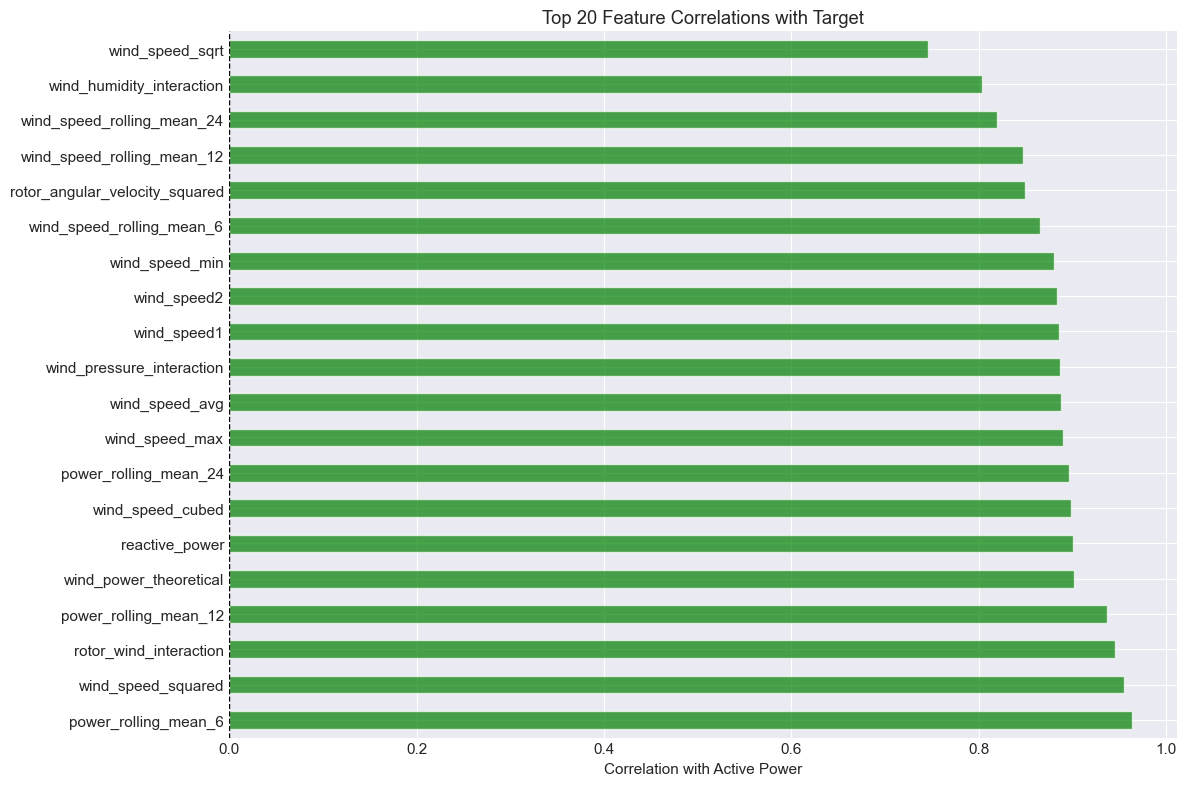

In [50]:
# Analyze correlation of new features with target
if 'active_power' in train_engineered.columns:
    numeric_cols = train_engineered.select_dtypes(include=[np.number]).columns
    correlations = train_engineered[numeric_cols].corr()['active_power'].sort_values(ascending=False)
    
    print("Top 20 Features Correlated with Active Power:")
    print("=" * 80)
    print(correlations.head(20))
    
    # Visualize top correlations
    fig, ax = plt.subplots(figsize=(12, 8))
    top_features = correlations.drop('active_power').head(20)
    colors = ['green' if x > 0 else 'red' for x in top_features.values]
    top_features.plot(kind='barh', ax=ax, color=colors, alpha=0.7)
    ax.set_xlabel('Correlation with Active Power')
    ax.set_title('Top 20 Feature Correlations with Target')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.tight_layout()
    plt.show()

### 2.1 Data Preparation

The engineered dataset is prepared for the modeling phase, including feature selection and handling of missing values.

In [51]:
# Define features to exclude
features_to_exclude = [
    'active_power',      # Target variable
    'timestamp',         # Not a feature
    'operational_state', # Categorical (could be encoded, but let's use its components)
    'wind_bin',          # Categorical
    'reactive_power'     # Might be leakage (generated alongside active power)
]

# Get feature names from training data
train_feature_names = [col for col in train_engineered.columns if col not in features_to_exclude]

# Get feature names from test data
test_feature_names = [col for col in test_engineered.columns if col not in features_to_exclude]

# Use only features that exist in BOTH train and test (exclude rolling features that are train-only)
feature_names = [col for col in train_feature_names if col in test_feature_names]

print(f"Total features in training data: {len(train_feature_names)}")
print(f"Total features in test data: {len(test_feature_names)}")
print(f"Common features for modeling: {len(feature_names)}")

# Show which features were excluded (if any)
train_only = set(train_feature_names) - set(feature_names)
if train_only:
    print(f"\nFeatures only in training (excluded): {len(train_only)}")
    print(f"  {sorted(train_only)}")

# Separate features and target
X = train_engineered[feature_names].copy()
y = train_engineered['active_power'].copy()
X_test = test_engineered[feature_names].copy()

# Handle any remaining NaN values
X = X.fillna(method='bfill').fillna(0)
X_test = X_test.fillna(method='bfill').fillna(0)

print(f"\nTraining features shape: {X.shape}")
print(f"Training target shape: {y.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"\nChecking for NaN values...")
print(f"Training NaNs: {X.isnull().sum().sum()}")
print(f"Test NaNs: {X_test.isnull().sum().sum()}")

Total features in training data: 64
Total features in test data: 55
Common features for modeling: 55

Features only in training (excluded): 9
  ['power_rolling_mean_12', 'power_rolling_mean_24', 'power_rolling_mean_6', 'wind_speed_rolling_mean_12', 'wind_speed_rolling_mean_24', 'wind_speed_rolling_mean_6', 'wind_speed_rolling_std_12', 'wind_speed_rolling_std_24', 'wind_speed_rolling_std_6']

Training features shape: (208910, 55)
Training target shape: (208910,)
Test features shape: (52228, 55)

Checking for NaN values...
Training NaNs: 0
Test NaNs: 0


In [52]:
# Temporal split for validation
split_index = int(0.8 * len(X))

X_train = X.iloc[:split_index]
X_val = X.iloc[split_index:]
y_train = y.iloc[:split_index]
y_val = y.iloc[split_index:]

print(f"Training set: {len(X_train):,} samples")
print(f"Validation set: {len(X_val):,} samples")
print(f"Test set: {len(X_test):,} samples")

# Scale features
scaler = RobustScaler()  # RobustScaler is better with outliers than StandardScaler

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=feature_names, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names, index=X_test.index)

print("\n✓ Data preparation complete!")

Training set: 167,128 samples
Validation set: 41,782 samples
Test set: 52,228 samples

✓ Data preparation complete!


## 3. Model Development

Various machine learning models are implemented and evaluated, with a focus on gradient boosting techniques which are suitable for tabular data.

### 3.1 Gradient Boosting Models

In [53]:
# Model evaluation function
def evaluate_model(model, X_train, y_train, X_val, y_val, model_name, fit_params=None):
    """Train and evaluate a model"""
    start_time = time.time()
    
    if fit_params:
        model.fit(X_train, y_train, **fit_params)
    else:
        model.fit(X_train, y_train)
    
    train_time = time.time() - start_time
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    
    # Metrics
    metrics = {
        'model': model_name,
        'train_mae': mean_absolute_error(y_train, y_pred_train),
        'val_mae': mean_absolute_error(y_val, y_pred_val),
        'train_rmse': np.sqrt(mean_squared_error(y_train, y_pred_train)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, y_pred_val)),
        'train_r2': r2_score(y_train, y_pred_train),
        'val_r2': r2_score(y_val, y_pred_val),
        'train_time': train_time
    }
    
    return metrics, model, y_pred_val

# Storage for results
advanced_results = []

print("Starting advanced model training...")
print("=" * 100)

Starting advanced model training...


In [54]:
# 1. XGBoost (if available)
if xgb is not None:
    print("\n" + "=" * 100)
    print("Training XGBoost...")
    print("=" * 100)
    
    xgb_model = xgb.XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        tree_method='hist'
    )
    
    eval_set = [(X_val_scaled, y_val)]
    fit_params = {
        'eval_set': eval_set,
        'verbose': 50
    }
    
    metrics, trained_xgb, xgb_preds = evaluate_model(
        xgb_model, X_train_scaled, y_train, X_val_scaled, y_val,
        'XGBoost', fit_params
    )
    advanced_results.append(metrics)
    
    print(f"\nXGBoost Results:")
    print(f"  Train MAE: {metrics['train_mae']:.2f} kW | Val MAE: {metrics['val_mae']:.2f} kW")
    print(f"  Train RMSE: {metrics['train_rmse']:.2f} kW | Val RMSE: {metrics['val_rmse']:.2f} kW")
    print(f"  Train R²: {metrics['train_r2']:.4f} | Val R²: {metrics['val_r2']:.4f}")
    print(f"  Training time: {metrics['train_time']:.2f}s")
else:
    print("\nXGBoost not available.")


Training XGBoost...
[0]	validation_0-rmse:349.52910
[50]	validation_0-rmse:32.24807
[100]	validation_0-rmse:15.68233
[150]	validation_0-rmse:15.23108
[200]	validation_0-rmse:15.16603
[250]	validation_0-rmse:15.11376
[300]	validation_0-rmse:15.08728
[350]	validation_0-rmse:15.08669
[400]	validation_0-rmse:15.06584
[450]	validation_0-rmse:15.06427
[499]	validation_0-rmse:15.05935

XGBoost Results:
  Train MAE: 4.99 kW | Val MAE: 6.12 kW
  Train RMSE: 9.31 kW | Val RMSE: 15.06 kW
  Train R²: 0.9996 | Val R²: 0.9982
  Training time: 5.00s


In [55]:
# 2. LightGBM (if available)
if lgb is not None:
    print("\n" + "=" * 100)
    print("Training LightGBM...")
    print("=" * 100)
    
    lgb_model = lgb.LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=8,
        num_leaves=31,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
    
    eval_set = [(X_val_scaled, y_val)]
    fit_params = {
        'eval_set': eval_set,
        'eval_metric': 'mae',
        'callbacks': [lgb.log_evaluation(50)]
    }
    
    metrics, trained_lgb, lgb_preds = evaluate_model(
        lgb_model, X_train_scaled, y_train, X_val_scaled, y_val,
        'LightGBM', fit_params
    )
    advanced_results.append(metrics)
    
    print(f"\nLightGBM Results:")
    print(f"  Train MAE: {metrics['train_mae']:.2f} kW | Val MAE: {metrics['val_mae']:.2f} kW")
    print(f"  Train RMSE: {metrics['train_rmse']:.2f} kW | Val RMSE: {metrics['val_rmse']:.2f} kW")
    print(f"  Train R²: {metrics['train_r2']:.4f} | Val R²: {metrics['val_r2']:.4f}")
    print(f"  Training time: {metrics['train_time']:.2f}s")
else:
    print("\nLightGBM not available.")


Training LightGBM...
[50]	valid_0's l1: 25.5486	valid_0's l2: 1263.4
[100]	valid_0's l1: 8.37114	valid_0's l2: 297.795
[150]	valid_0's l1: 7.21311	valid_0's l2: 264.796
[200]	valid_0's l1: 7.04633	valid_0's l2: 254.964
[250]	valid_0's l1: 6.95015	valid_0's l2: 249.424
[300]	valid_0's l1: 6.88432	valid_0's l2: 246.61
[350]	valid_0's l1: 6.8339	valid_0's l2: 244.369
[400]	valid_0's l1: 6.78796	valid_0's l2: 242.344
[450]	valid_0's l1: 6.74396	valid_0's l2: 240.045
[500]	valid_0's l1: 6.72114	valid_0's l2: 238.746

LightGBM Results:
  Train MAE: 7.35 kW | Val MAE: 6.72 kW
  Train RMSE: 14.30 kW | Val RMSE: 15.45 kW
  Train R²: 0.9989 | Val R²: 0.9981
  Training time: 1.82s


In [56]:
# 3. CatBoost (if available)
if cb is not None:
    print("\n" + "=" * 100)
    print("Training CatBoost...")
    print("=" * 100)
    
    cb_model = cb.CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=8,
        l2_leaf_reg=3,
        random_state=RANDOM_STATE,
        verbose=50,
        thread_count=-1
    )
    
    eval_set = (X_val_scaled, y_val)
    fit_params = {
        'eval_set': eval_set,
        'use_best_model': True,
        'verbose': 50
    }
    
    metrics, trained_cb, cb_preds = evaluate_model(
        cb_model, X_train_scaled, y_train, X_val_scaled, y_val,
        'CatBoost', fit_params
    )
    advanced_results.append(metrics)
    
    print(f"\nCatBoost Results:")
    print(f"  Train MAE: {metrics['train_mae']:.2f} kW | Val MAE: {metrics['val_mae']:.2f} kW")
    print(f"  Train RMSE: {metrics['train_rmse']:.2f} kW | Val RMSE: {metrics['val_rmse']:.2f} kW")
    print(f"  Train R²: {metrics['train_r2']:.4f} | Val R²: {metrics['val_r2']:.4f}")
    print(f"  Training time: {metrics['train_time']:.2f}s")
else:
    print("\nCatBoost not available.")


Training CatBoost...
0:	learn: 419.7620999	test: 349.9317120	best: 349.9317120 (0)	total: 19.4ms	remaining: 9.67s
50:	learn: 45.6120821	test: 38.7408567	best: 38.7408567 (50)	total: 958ms	remaining: 8.44s
100:	learn: 24.9050060	test: 21.5728151	best: 21.5728151 (100)	total: 1.99s	remaining: 7.86s
150:	learn: 22.0925784	test: 19.5577167	best: 19.5577167 (150)	total: 3.05s	remaining: 7.05s
200:	learn: 20.5073501	test: 18.6485867	best: 18.6485867 (200)	total: 4.16s	remaining: 6.18s
250:	learn: 19.3995884	test: 18.0010748	best: 18.0010748 (250)	total: 5.17s	remaining: 5.13s
300:	learn: 18.4809783	test: 17.4534943	best: 17.4534943 (300)	total: 6.18s	remaining: 4.09s
350:	learn: 17.7733533	test: 17.0558620	best: 17.0558620 (350)	total: 7.18s	remaining: 3.05s
400:	learn: 17.1970054	test: 16.7623417	best: 16.7623417 (400)	total: 8.16s	remaining: 2.01s
450:	learn: 16.7389983	test: 16.5540169	best: 16.5540169 (450)	total: 9.06s	remaining: 984ms
499:	learn: 16.3312488	test: 16.3429620	best: 16.3

In [57]:
# 4. Gradient Boosting (sklearn)
print("\n" + "=" * 100)
print("Training Gradient Boosting (sklearn)...")
print("=" * 100)

gb_model = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=7,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    random_state=RANDOM_STATE,
    verbose=0
)

metrics, trained_gb, gb_preds = evaluate_model(
    gb_model, X_train_scaled, y_train, X_val_scaled, y_val,
    'Gradient Boosting'
)
advanced_results.append(metrics)

print(f"\nGradient Boosting Results:")
print(f"  Train MAE: {metrics['train_mae']:.2f} kW | Val MAE: {metrics['val_mae']:.2f} kW")
print(f"  Train RMSE: {metrics['train_rmse']:.2f} kW | Val RMSE: {metrics['val_rmse']:.2f} kW")
print(f"  Train R²: {metrics['train_r2']:.4f} | Val R²: {metrics['val_r2']:.4f}")
print(f"  Training time: {metrics['train_time']:.2f}s")


Training Gradient Boosting (sklearn)...

Gradient Boosting Results:
  Train MAE: 6.47 kW | Val MAE: 6.16 kW
  Train RMSE: 12.96 kW | Val RMSE: 15.08 kW
  Train R²: 0.9991 | Val R²: 0.9982
  Training time: 681.59s


In [58]:
# 5. Random Forest (with more trees)
print("\n" + "=" * 100)
print("Training Random Forest...")
print("=" * 100)

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)

metrics, trained_rf, rf_preds = evaluate_model(
    rf_model, X_train_scaled, y_train, X_val_scaled, y_val,
    'Random Forest'
)
advanced_results.append(metrics)

print(f"\nRandom Forest Results:")
print(f"  Train MAE: {metrics['train_mae']:.2f} kW | Val MAE: {metrics['val_mae']:.2f} kW")
print(f"  Train RMSE: {metrics['train_rmse']:.2f} kW | Val RMSE: {metrics['val_rmse']:.2f} kW")
print(f"  Train R²: {metrics['train_r2']:.4f} | Val R²: {metrics['val_r2']:.4f}")
print(f"  Training time: {metrics['train_time']:.2f}s")


Training Random Forest...

Random Forest Results:
  Train MAE: 5.75 kW | Val MAE: 6.95 kW
  Train RMSE: 12.97 kW | Val RMSE: 16.52 kW
  Train R²: 0.9991 | Val R²: 0.9978
  Training time: 9.84s


### 3.2 Model Comparison


ADVANCED MODEL COMPARISON
            model  train_mae  val_mae  train_rmse  val_rmse  train_r2   val_r2  train_time
          XGBoost   4.994116 6.123256    9.310099 15.059349  0.999555 0.998196    5.003071
Gradient Boosting   6.466793 6.161485   12.964270 15.076078  0.999136 0.998192  681.587681
         LightGBM   7.346183 6.721136   14.302352 15.451421  0.998949 0.998101    1.815986
    Random Forest   5.749312 6.947032   12.971826 16.516455  0.999135 0.997831    9.838741
         CatBoost   8.968255 7.966935   16.331249 16.342962  0.998630 0.997876   11.054983

Best Model: XGBoost
   Validation MAE: 6.12 kW
   Validation RMSE: 15.06 kW
   Validation R²: 0.9982


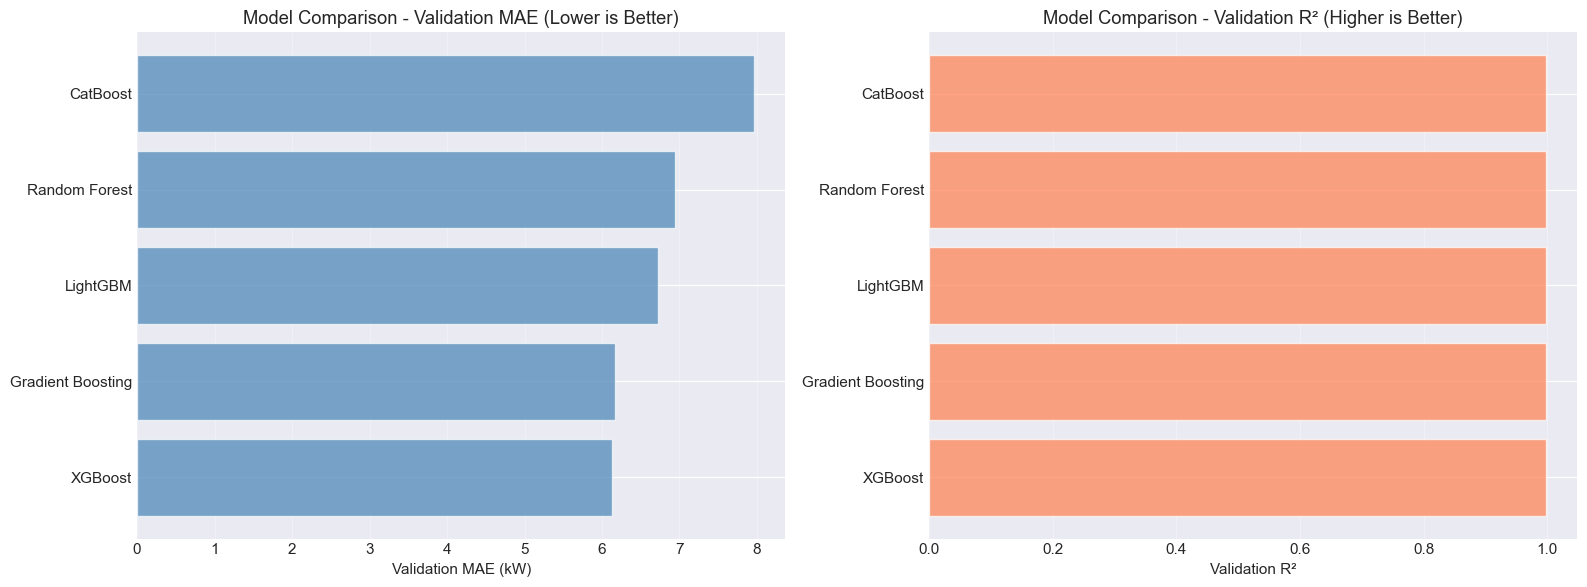

In [59]:
# Create comparison DataFrame
if advanced_results:
    results_df = pd.DataFrame(advanced_results).sort_values('val_mae')
    
    print("\n" + "=" * 120)
    print("ADVANCED MODEL COMPARISON")
    print("=" * 120)
    print(results_df.to_string(index=False))
    print("=" * 120)
    
    best_model_info = results_df.iloc[0]
    print(f"\nBest Model: {best_model_info['model']}")
    print(f"   Validation MAE: {best_model_info['val_mae']:.2f} kW")
    print(f"   Validation RMSE: {best_model_info['val_rmse']:.2f} kW")
    print(f"   Validation R²: {best_model_info['val_r2']:.4f}")
    
    # Visualize comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # MAE comparison
    x_pos = np.arange(len(results_df))
    axes[0].barh(x_pos, results_df['val_mae'], alpha=0.7, color='steelblue')
    axes[0].set_yticks(x_pos)
    axes[0].set_yticklabels(results_df['model'])
    axes[0].set_xlabel('Validation MAE (kW)')
    axes[0].set_title('Model Comparison - Validation MAE (Lower is Better)')
    axes[0].grid(True, alpha=0.3, axis='x')
    
    # R² comparison
    axes[1].barh(x_pos, results_df['val_r2'], alpha=0.7, color='coral')
    axes[1].set_yticks(x_pos)
    axes[1].set_yticklabels(results_df['model'])
    axes[1].set_xlabel('Validation R²')
    axes[1].set_title('Model Comparison - Validation R² (Higher is Better)')
    axes[1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nNo models were trained successfully.")

### 3.3 Feature Importance Analysis

Analyzing feature importance provides insights into the drivers of model predictions.


Top 20 Important Features - XGBoost
                       feature  importance
        rotor_wind_interaction    0.547059
rotor_angular_velocity_squared    0.197871
        wind_power_theoretical    0.127070
        rotor_angular_velocity    0.091898
     wind_pressure_interaction    0.015583
                wind_speed_min    0.011807
              wind_speed_cubed    0.002845
                wind_speed_avg    0.001760
                   pitch_angle    0.000900
           pitch_angle_squared    0.000271
                   temp_kelvin    0.000220
             air_density_proxy    0.000219
                  outdoor_temp    0.000206
                   wind_speed2    0.000189
              wind_speed_ratio    0.000109
                     month_sin    0.000087
                  weather_temp    0.000085
            wind_speed_squared    0.000084
                wind_vane_diff    0.000082
                 dayofyear_cos    0.000081


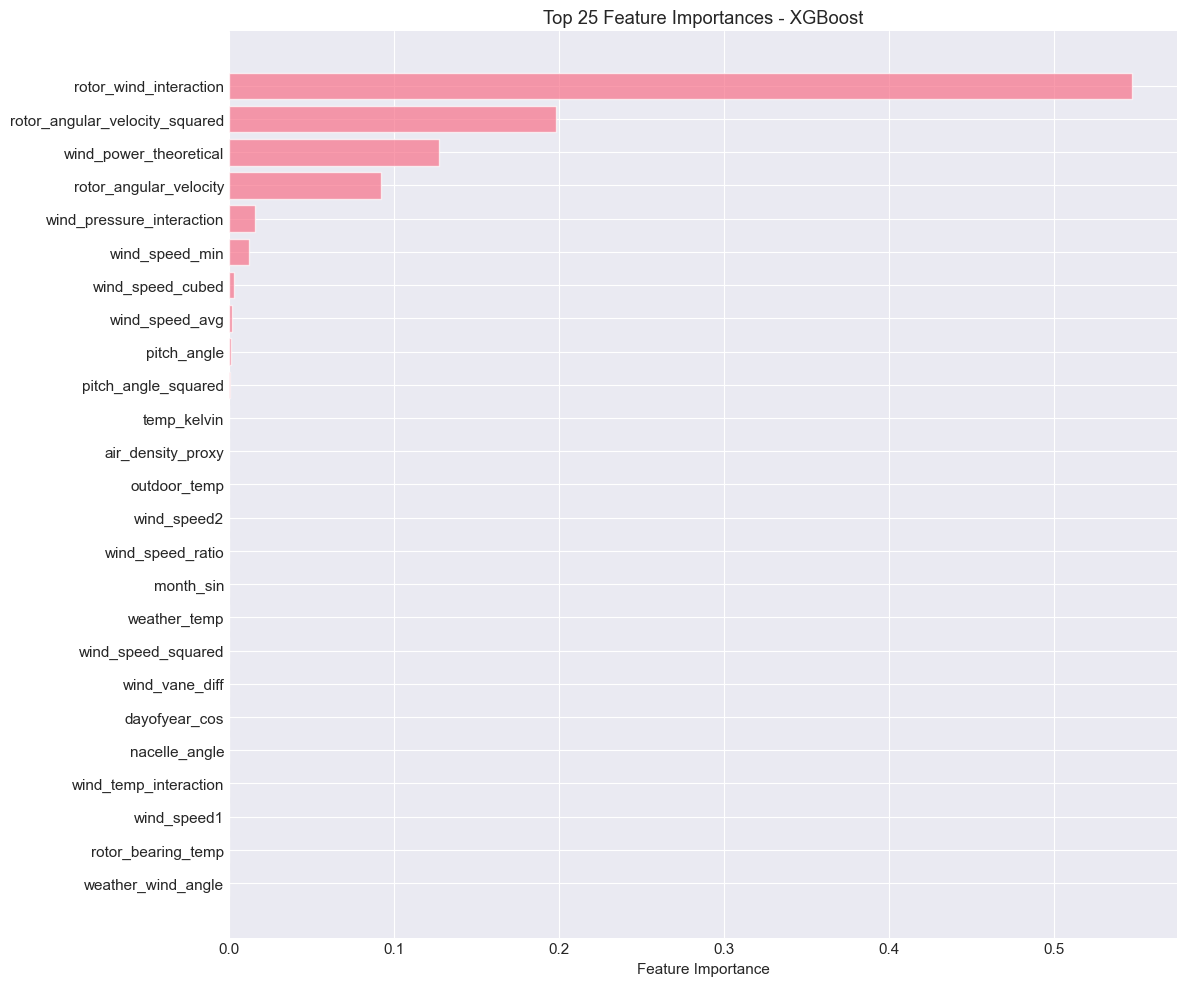

In [60]:
# Analyze feature importance from best model
if advanced_results and len(advanced_results) > 0:
    best_model_name = results_df.iloc[0]['model']
    
    # Get the trained model
    if best_model_name == 'XGBoost' and xgb is not None:
        best_model = trained_xgb
    elif best_model_name == 'LightGBM' and lgb is not None:
        best_model = trained_lgb
    elif best_model_name == 'CatBoost' and cb is not None:
        best_model = trained_cb
    elif best_model_name == 'Gradient Boosting':
        best_model = trained_gb
    elif best_model_name == 'Random Forest':
        best_model = trained_rf
    
    # Get feature importance
    if hasattr(best_model, 'feature_importances_'):
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': best_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(f"\n{'='*80}")
        print(f"Top 20 Important Features - {best_model_name}")
        print(f"{'='*80}")
        print(importance_df.head(20).to_string(index=False))
        
        # Visualize
        fig, ax = plt.subplots(figsize=(12, 10))
        top_n = 25
        top_features = importance_df.head(top_n)
        ax.barh(range(top_n), top_features['importance'], alpha=0.7)
        ax.set_yticks(range(top_n))
        ax.set_yticklabels(top_features['feature'])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'Top {top_n} Feature Importances - {best_model_name}')
        ax.invert_yaxis()
        plt.tight_layout()
        plt.show()

## 4. Error Analysis

A detailed analysis of prediction errors is conducted to identify areas for model improvement.


Error Analysis - XGBoost
Mean Absolute Error: 6.12 kW
Median Absolute Error: 1.61 kW
90th Percentile Error: 15.65 kW
95th Percentile Error: 31.09 kW
Max Error: 393.87 kW


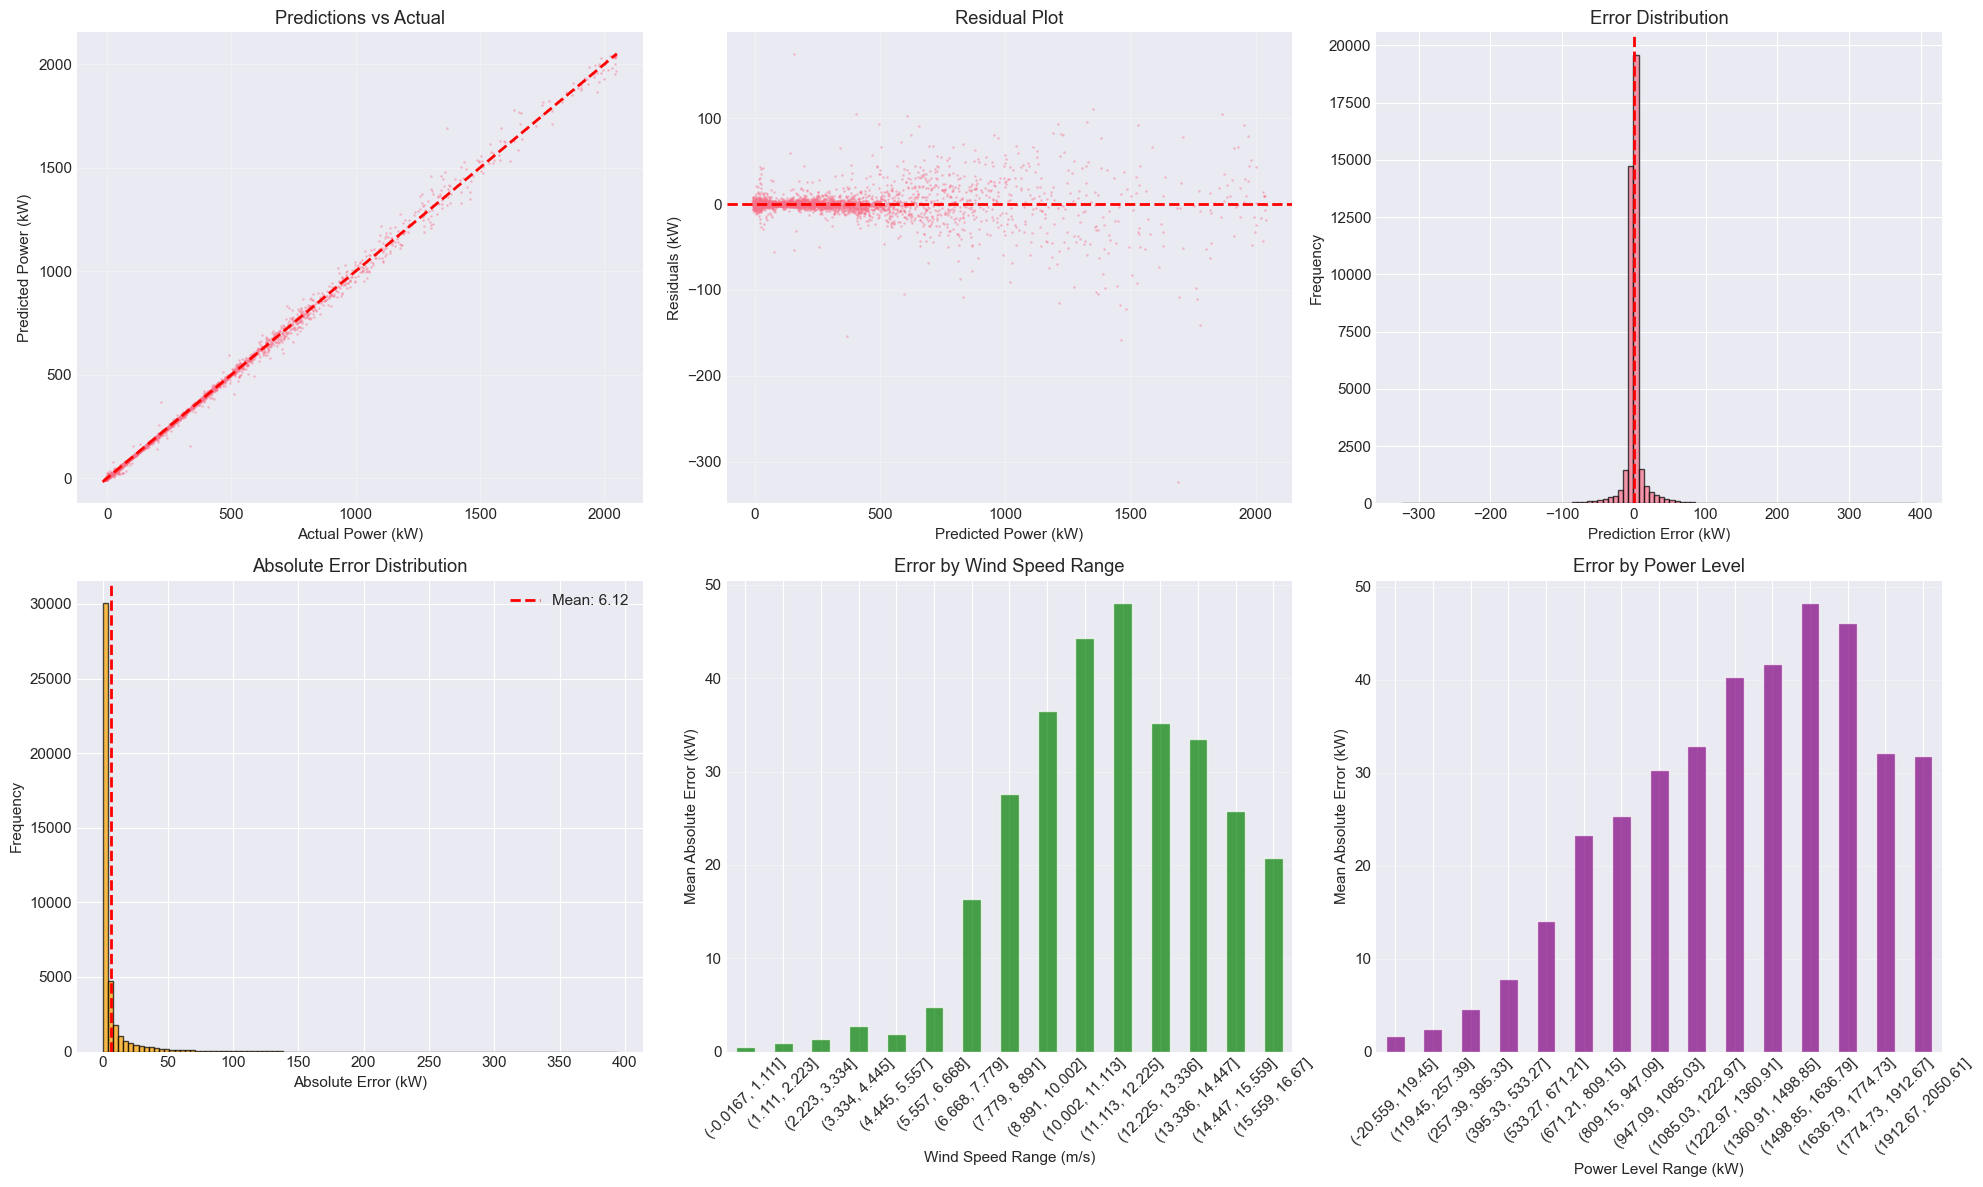


10 Worst Predictions:
 1. Actual:  887.80 kW | Predicted:  493.93 kW | Error:  393.87 kW
 2. Actual: 1366.53 kW | Predicted: 1689.89 kW | Error:  323.36 kW
 3. Actual:  418.30 kW | Predicted:  705.28 kW | Error:  286.98 kW
 4. Actual:  655.70 kW | Predicted:  411.40 kW | Error:  244.30 kW
 5. Actual: 1256.97 kW | Predicted: 1023.51 kW | Error:  233.46 kW
 6. Actual:  345.98 kW | Predicted:  114.60 kW | Error:  231.38 kW
 7. Actual: 1492.37 kW | Predicted: 1684.64 kW | Error:  192.27 kW
 8. Actual: 1528.90 kW | Predicted: 1720.95 kW | Error:  192.05 kW
 9. Actual: 1351.70 kW | Predicted: 1165.59 kW | Error:  186.11 kW
10. Actual: 1617.50 kW | Predicted: 1800.64 kW | Error:  183.14 kW


In [61]:
# Error analysis on best model
if advanced_results and len(advanced_results) > 0:
    best_model_name = results_df.iloc[0]['model']
    
    # Get predictions from best model
    if best_model_name == 'XGBoost' and xgb is not None:
        y_pred = xgb_preds
    elif best_model_name == 'LightGBM' and lgb is not None:
        y_pred = lgb_preds
    elif best_model_name == 'CatBoost' and cb is not None:
        y_pred = cb_preds
    elif best_model_name == 'Gradient Boosting':
        y_pred = gb_preds
    elif best_model_name == 'Random Forest':
        y_pred = rf_preds
    
    # Calculate errors
    errors = y_val.values - y_pred
    abs_errors = np.abs(errors)
    
    print(f"\n{'='*80}")
    print(f"Error Analysis - {best_model_name}")
    print(f"{'='*80}")
    print(f"Mean Absolute Error: {np.mean(abs_errors):.2f} kW")
    print(f"Median Absolute Error: {np.median(abs_errors):.2f} kW")
    print(f"90th Percentile Error: {np.percentile(abs_errors, 90):.2f} kW")
    print(f"95th Percentile Error: {np.percentile(abs_errors, 95):.2f} kW")
    print(f"Max Error: {np.max(abs_errors):.2f} kW")
    
    # Visualize errors
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    
    # 1. Predictions vs Actual
    sample_size = min(5000, len(y_val))
    sample_idx = np.random.choice(len(y_val), sample_size, replace=False)
    axes[0, 0].scatter(y_val.iloc[sample_idx], y_pred[sample_idx], alpha=0.3, s=1)
    axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
    axes[0, 0].set_xlabel('Actual Power (kW)')
    axes[0, 0].set_ylabel('Predicted Power (kW)')
    axes[0, 0].set_title('Predictions vs Actual')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Residuals vs Predicted
    axes[0, 1].scatter(y_pred[sample_idx], errors[sample_idx], alpha=0.3, s=1)
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted Power (kW)')
    axes[0, 1].set_ylabel('Residuals (kW)')
    axes[0, 1].set_title('Residual Plot')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Error distribution
    axes[0, 2].hist(errors, bins=100, edgecolor='black', alpha=0.7)
    axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 2].set_xlabel('Prediction Error (kW)')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Error Distribution')
    
    # 4. Absolute error distribution
    axes[1, 0].hist(abs_errors, bins=100, edgecolor='black', alpha=0.7, color='orange')
    axes[1, 0].axvline(x=np.mean(abs_errors), color='r', linestyle='--', lw=2, label=f'Mean: {np.mean(abs_errors):.2f}')
    axes[1, 0].set_xlabel('Absolute Error (kW)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Absolute Error Distribution')
    axes[1, 0].legend()
    
    # 5. Error by wind speed (if available)
    val_wind_speed = X_val['wind_speed_avg'].values
    wind_bins = pd.cut(val_wind_speed, bins=15)
    error_by_wind = pd.DataFrame({
        'wind_bin': wind_bins,
        'abs_error': abs_errors
    }).groupby('wind_bin')['abs_error'].mean()
    
    error_by_wind.plot(kind='bar', ax=axes[1, 1], color='green', alpha=0.7)
    axes[1, 1].set_xlabel('Wind Speed Range (m/s)')
    axes[1, 1].set_ylabel('Mean Absolute Error (kW)')
    axes[1, 1].set_title('Error by Wind Speed Range')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # 6. Error by actual power level
    power_bins = pd.cut(y_val.values, bins=15)
    error_by_power = pd.DataFrame({
        'power_bin': power_bins,
        'abs_error': abs_errors
    }).groupby('power_bin')['abs_error'].mean()
    
    error_by_power.plot(kind='bar', ax=axes[1, 2], color='purple', alpha=0.7)
    axes[1, 2].set_xlabel('Power Level Range (kW)')
    axes[1, 2].set_ylabel('Mean Absolute Error (kW)')
    axes[1, 2].set_title('Error by Power Level')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Identify worst predictions
    worst_idx = np.argsort(abs_errors)[-10:]
    print(f"\n{'='*80}")
    print("10 Worst Predictions:")
    print(f"{'='*80}")
    for i, idx in enumerate(worst_idx[::-1], 1):
        actual_idx = y_val.index[idx]
        print(f"{i:2d}. Actual: {y_val.iloc[idx]:7.2f} kW | Predicted: {y_pred[idx]:7.2f} kW | Error: {abs_errors[idx]:7.2f} kW")

## 5. Prediction Generation

Predictions are generated using the best-performing models for the test dataset.

In [62]:
# Function to create submission
def create_submission(predictions, filename):
    """Create submission CSV file"""
    submission = pd.DataFrame({
        'id': range(len(predictions)),
        'active_power': predictions
    })
    
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    full_filename = f"../results/{filename}_{timestamp}.csv"
    
    submission.to_csv(full_filename, index=False)
    
    print(f"Submission created: {full_filename}")
    print(f"  Predictions: {len(predictions):,}")
    print(f"  Mean: {predictions.mean():.2f} kW")
    print(f"  Std: {predictions.std():.2f} kW")
    print(f"  Range: [{predictions.min():.2f}, {predictions.max():.2f}] kW")
    
    return submission

# Generate predictions for all trained models
if advanced_results:
    print("\n" + "=" * 80)
    print("Generating Test Predictions")
    print("=" * 80)
    
    if xgb is not None and 'trained_xgb' in locals():
        print("\nXGBoost predictions...")
        xgb_test_preds = trained_xgb.predict(X_test_scaled)
        create_submission(xgb_test_preds, "xgboost_submission")
    
    if lgb is not None and 'trained_lgb' in locals():
        print("\nLightGBM predictions...")
        lgb_test_preds = trained_lgb.predict(X_test_scaled)
        create_submission(lgb_test_preds, "lightgbm_submission")
    
    if cb is not None and 'trained_cb' in locals():
        print("\nCatBoost predictions...")
        cb_test_preds = trained_cb.predict(X_test_scaled)
        create_submission(cb_test_preds, "catboost_submission")
    
    if 'trained_gb' in locals():
        print("\nGradient Boosting predictions...")
        gb_test_preds = trained_gb.predict(X_test_scaled)
        create_submission(gb_test_preds, "gradient_boosting_submission")
    
    if 'trained_rf' in locals():
        print("\nRandom Forest predictions...")
        rf_test_preds = trained_rf.predict(X_test_scaled)
        create_submission(rf_test_preds, "random_forest_submission")
    
    print("\nAll predictions generated!")


Generating Test Predictions

XGBoost predictions...
Submission created: ../results/xgboost_submission_20251121-181439.csv
  Predictions: 52,228
  Mean: 355.95 kW
  Std: 461.29 kW
  Range: [-43.73, 2064.48] kW

LightGBM predictions...
Submission created: ../results/lightgbm_submission_20251121-181439.csv
  Predictions: 52,228
  Mean: 357.18 kW
  Std: 462.35 kW
  Range: [-58.02, 2089.85] kW

CatBoost predictions...
Submission created: ../results/catboost_submission_20251121-181439.csv
  Predictions: 52,228
  Mean: 355.09 kW
  Std: 460.44 kW
  Range: [-40.60, 2094.39] kW

Gradient Boosting predictions...
Submission created: ../results/gradient_boosting_submission_20251121-181439.csv
  Predictions: 52,228
  Mean: 355.38 kW
  Std: 461.30 kW
  Range: [-78.14, 2070.34] kW

Random Forest predictions...
Submission created: ../results/random_forest_submission_20251121-181440.csv
  Predictions: 52,228
  Mean: 355.56 kW
  Std: 460.61 kW
  Range: [-9.48, 2041.30] kW

All predictions generated!


## 6. Conclusion and Next Steps

### Summary

1. **Exploratory Data Analysis**: Identified key operational states and data characteristics.
2. **Feature Engineering**: Developed physics-based and temporal features.
3. **Model Development**: Implemented and compared gradient boosting algorithms.
4. **Error Analysis**: Evaluated model performance and error distributions.

### Project Roadmap

The following notebooks in this project will address:

1. **Hyperparameter Optimization**: Systematic tuning using Optuna (Notebook 02).
2. **Ensemble Methods**: Stacking and blending of multiple models (Notebook 03).
3. **Advanced Architectures**: Exploration of neural networks to compare with gradient boosting (Notebook 04).

## 7. Model Persistence

Saving the trained models and preprocessing objects for future use.

In [63]:
# Save best model and scaler
import pickle

if advanced_results:
    best_model_name = results_df.iloc[0]['model']
    
    # Save the appropriate model
    if best_model_name == 'XGBoost' and 'trained_xgb' in locals():
        with open('../models/best_model_xgb.pkl', 'wb') as f:
            pickle.dump(trained_xgb, f)
        print(f"Saved {best_model_name} model")
    elif best_model_name == 'LightGBM' and 'trained_lgb' in locals():
        with open('../models/best_model_lgb.pkl', 'wb') as f:
            pickle.dump(trained_lgb, f)
        print(f"Saved {best_model_name} model")
    elif best_model_name == 'CatBoost' and 'trained_cb' in locals():
        trained_cb.save_model('../models/best_model_catboost.cbm')
        print(f"Saved {best_model_name} model")
    elif best_model_name == 'Gradient Boosting':
        with open('../models/best_model_gb.pkl', 'wb') as f:
            pickle.dump(trained_gb, f)
        print(f"Saved {best_model_name} model")
    elif best_model_name == 'Random Forest':
        with open('../models/best_model_rf.pkl', 'wb') as f:
            pickle.dump(trained_rf, f)
        print(f"Saved {best_model_name} model")
    
    # Save scaler
    with open('../models/feature_scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    print("Saved feature scaler")
    
    # Save feature names
    with open('../models/feature_names.pkl', 'wb') as f:
        pickle.dump(feature_names, f)
    print("Saved feature names")
    
    print("\nAll artifacts saved successfully!")

Saved XGBoost model
Saved feature scaler
Saved feature names

All artifacts saved successfully!
